## Explorations with torch-dreams on inceptionv3
Our objectives in this notebook are:
1. Optimize random noise to maximize activations of particular channels within the model
2. Optimize random noise on 2 different channels simultaneously to create "blends"

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from torch_dreams.dreamer import dreamer
import torchvision.models as models 

## First off, let's start  by generating some random noise for experiments 

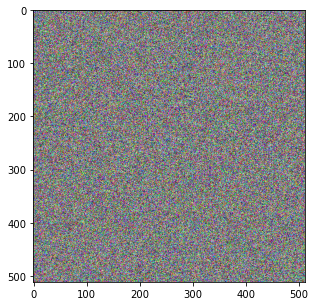

True

In [2]:

image_sample = (np.random.rand(512,512,3).astype(np.float32) *255).astype(np.uint8)
plt.rcParams['figure.figsize'] = 5,5
# print(image_sample.max(), image_sample.min())
plt.imshow(image_sample)
plt.show()
cv2.imwrite("images/noise.jpg", image_sample)

## Initiating the `torch_dreams.dreamer`

In [3]:
model = models.inception_v3(pretrained=True)
dreamy_boi = dreamer(model)


dreamer init on:  cuda


## Choosing the layers we want to experiment on

In [12]:

layer = model.Mixed_6c.branch7x7_1.conv
layer_2 = model.Mixed_6c.branch7x7dbl_3.conv


layers_to_use = [layer, layer_2]
# layers_to_use

## Blending 2 channels from `model.Mixed_6c.branch7x7_1.conv`
* We blend channel `70` and channel `10` from `model.Mixed_6c.branch7x7_1.conv`. 
* we blend them individually first and then simultaneously

In [64]:
def my_custom_func(layer_outputs):
    
    loss = layer_outputs[0][70].norm()
#     print(loss)
    return loss

out_single_conv = dreamy_boi.deep_dream(
    image_path = "images/noise.jpg",
    layers = layers_to_use,
    octave_scale = 1.1,
    num_octaves = 11,
    iterations = 200,
    lr = 4.9,
    custom_func =  my_custom_func,
    max_rotation =  0.3
)

100%|██████████| 12/12 [01:18<00:00,  6.57s/it]


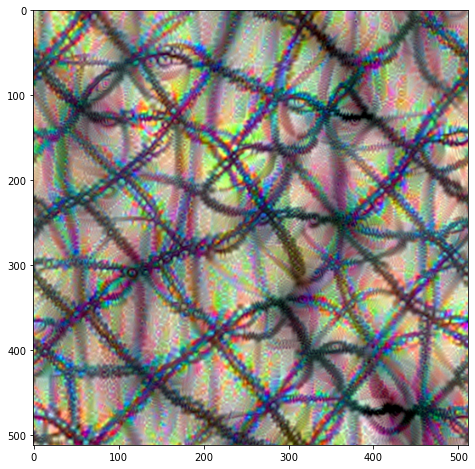

In [65]:
plt.rcParams['figure.figsize'] = 8, 8
plt.imshow(out_single_conv)
plt.show()


In [71]:
def my_custom_func(layer_outputs):
    
    loss = layer_outputs[0][10].norm()
#     print(loss)
    return loss

out_single_conv_2 = dreamy_boi.deep_dream(
    image_path = "images/noise.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 9,
    iterations = 200,
    lr = 6.9,
    custom_func =  my_custom_func,
    max_rotation =  0.3
)

100%|██████████| 10/10 [01:02<00:00,  6.21s/it]


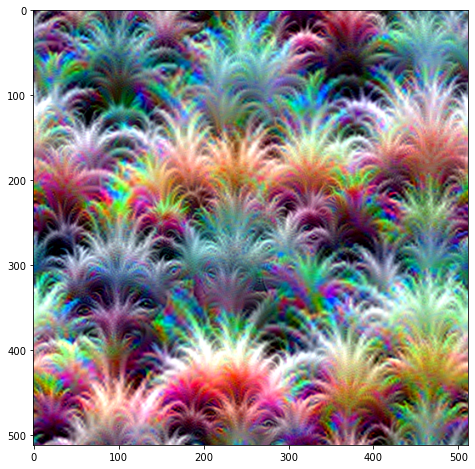

In [72]:
plt.rcParams['figure.figsize'] = 8, 8
plt.imshow(out_single_conv_2)
plt.show()


In [76]:
def my_custom_func(layer_outputs):
    
    loss = layer_outputs[0][10].norm() + layer_outputs[0][70].norm()
#     print(loss)
    return loss

out_single_conv_blend = dreamy_boi.deep_dream(
    image_path = "images/noise.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 8,
    iterations = 200,
    lr = 5.9,
    custom_func =  my_custom_func,
    max_rotation =  0.3
)

100%|██████████| 9/9 [01:00<00:00,  6.68s/it]


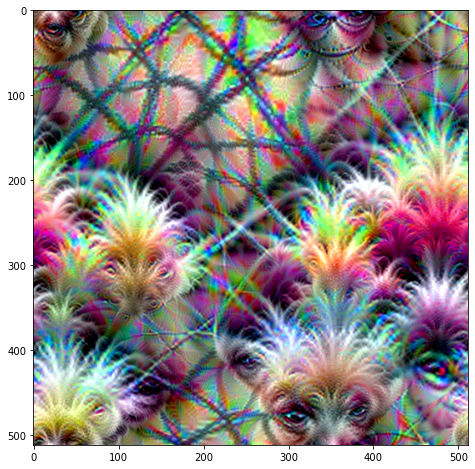

In [146]:
plt.rcParams['figure.figsize'] = 8, 8
plt.imshow(out_single_conv_blend)
plt.show()


## Saving the generated images before moving on 

In [95]:
common_name = "inceptionv3.Mixed_6c.branch7x7_1.conv"
save_folder = "images/raw_output/set2"
names = [
    save_folder + "/" + common_name + "_channel_70.jpg",
    save_folder + "/" + common_name + "_channel_10.jpg",
    save_folder + "/" + "blend_" + common_name + "_channel_10_70.jpg"

]

In [97]:
images = [
    out_single_conv*255,
    out_single_conv_2*255,
    out_single_conv_blend*255
]

In [101]:
for i in range(len(images)):
    cv2.imwrite(names[i], cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    print("saved: ", names[i])

saved:  images/raw_output/set2/inceptionv3.Mixed_6c.branch7x7_1.conv_channel_70.jpg
saved:  images/raw_output/set2/inceptionv3.Mixed_6c.branch7x7_1.conv_channel_10.jpg
saved:  images/raw_output/set2/blend_inceptionv3.Mixed_6c.branch7x7_1.conv_channel_10_70.jpg


## Generating visualizations for a lot of channels 

In [60]:
layers_to_use[0]

Conv2d(768, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [ ]:
all_channel_activations = []
for i in range(0, 24,1):
    def my_custom_func(layer_outputs):
    
        loss = layer_outputs[0][i].norm()
    #     print(loss)
        return loss

    out = dreamy_boi.deep_dream(
        image_path = "images/noise.jpg",
        layers = layers_to_use,
        octave_scale = 1.2,
        num_octaves = 9,
        iterations = 200,
        lr = 6.9,
        custom_func =  my_custom_func,
        max_rotation =  0.3
    )
    all_channel_activations.append(out)
#     plt.imshow(out)
#     plt.show()

In [58]:
len(all_channel_activations)

24

In [76]:
cherry_picked_indices = [4, 1,6,22,2,7, 12, 15, 16, 17, 5, 17]
len(cherry_picked_indices)

12

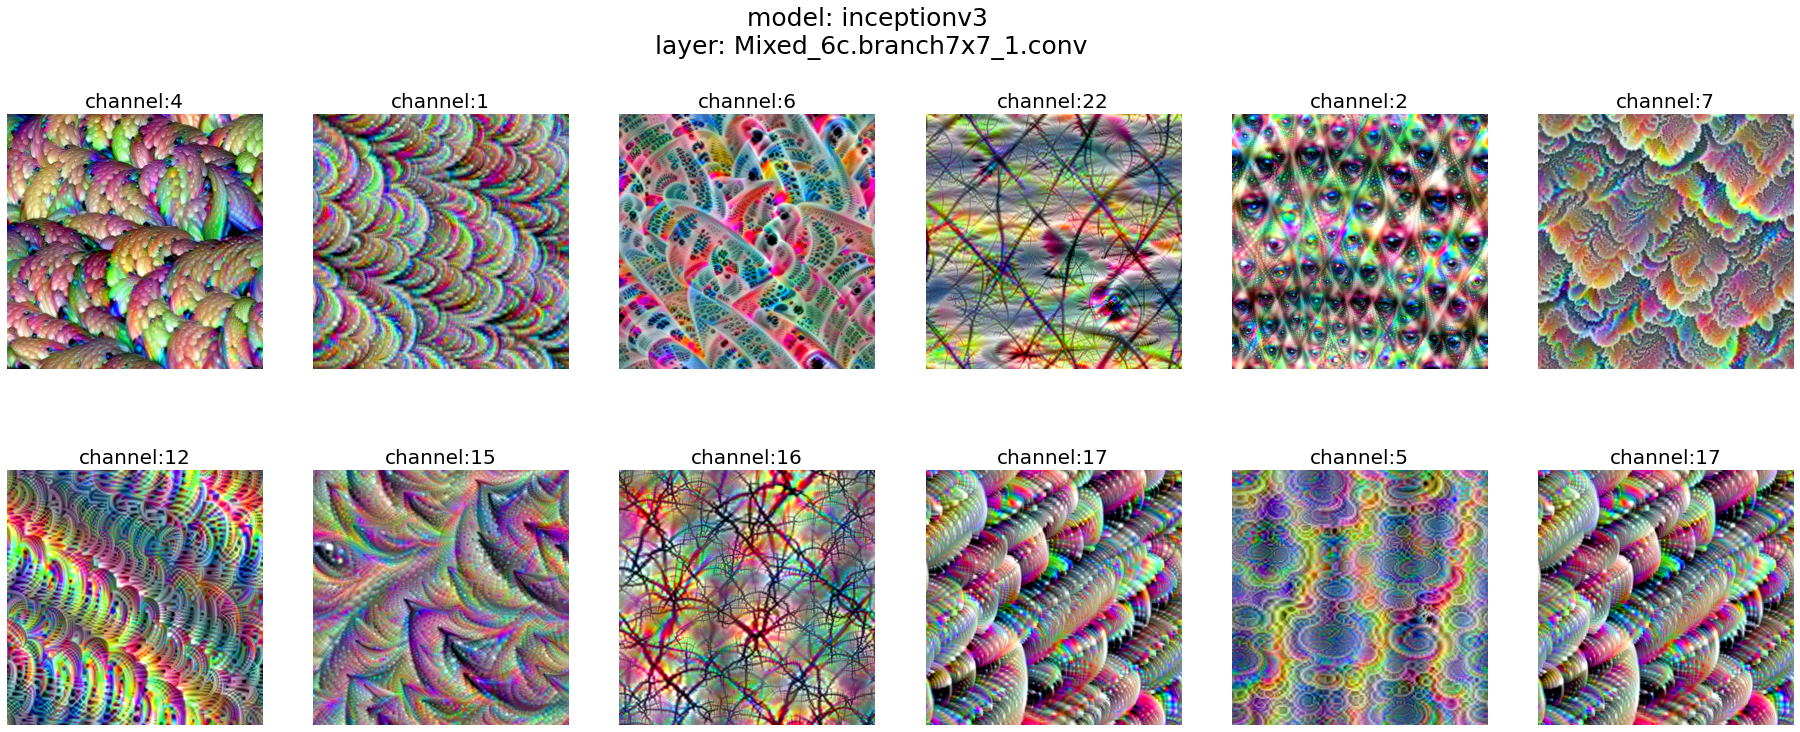

In [80]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize = (16*2,6*2))
fig.suptitle('model: inceptionv3 \n layer: Mixed_6c.branch7x7_1.conv \n', fontsize=25)

j = 0
for i in cherry_picked_indices:
#     print(i,j)
    ax.flat[j].imshow(all_channel_activations[i])
    ax.flat[j].axis("off")
    ax.flat[j].set_facecolor("white")
    ax.flat[j].set_title("channel:" + str(i), fontsize = 20)
    j+=1

In [78]:
fig.savefig("images/inceptionv3_cherrypicked_channels.jpg")

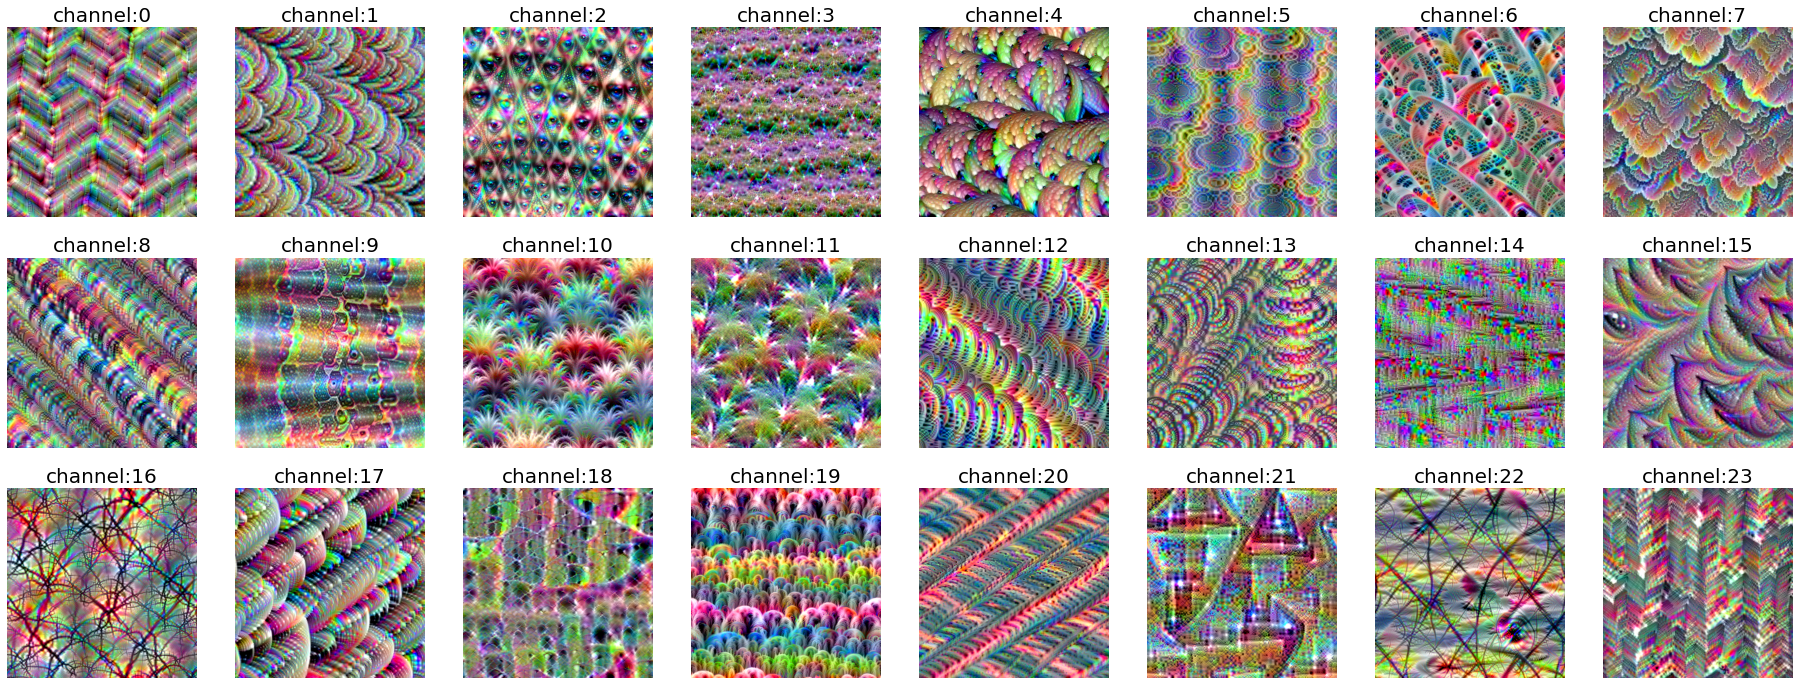

In [69]:
fig, ax = plt.subplots(nrows=3, ncols=8, figsize = (16*2,6*2))

j = 0
for i in all_channel_activations:
#     print(i,j)
    ax.flat[j].imshow(i)
    ax.flat[j].axis("off")
    ax.flat[j].set_facecolor("white")
    ax.flat[j].set_title("channel:" + str(j), fontsize = 20)

    j+=1

In [95]:
save_folder = "images/raw_outputs/inceptionv3_channels/"

names = [
    save_folder + "inceptionv3.Mixed_6c.branch7x7_1.conv_channel_" + str(i) + ".jpg" for i in range(24)
]

In [ ]:
for i in range(len(all_channel_activations)):
    cv2.imwrite(names[i], cv2.cvtColor(all_channel_activations[i]*255, cv2.COLOR_BGR2RGB))
    print("saved: ", names[i])